# Example on how to configure a case using mom6-tools

This is a very simple example showing how to read `diag_config.yaml`, create a case instance, compute a climatology and visualize the results.

### Case Information
- **Case:**
  - **CASEROOT**: Path to the root directory of the case:  
    `/glade/work/gmarques/cesm.cases/G/g.e30_a03c.GJRAv4.TL319_t232_wgx3_hycom1_N75.2024.079/`
  - **OCN_DIAG_ROOT**: Directory for ocean diagnostics files:  
    `ncfiles/`
  - **SNAME**: Identifier or short name of the case:  
    `"079"`

---

### Average Dates
- **Avg:**
  - **start_date**: Start date for averaging data:  
    `'0031-01-01'`
  - **end_date**: End date for averaging data:  
    `'0062-01-01'`

---

### CESM History File Naming Conventions
- **Fnames:**
  - **rho2**: Format for density files:  
    `.mom6.h.rho2.????-??.nc`
  - **z**: Format for depth files:  
    `.mom6.h.z.????-??.nc`
  - **native**: Format for native files:  
    `.mom6.h.native.????-??.nc`
  - **sfc**: Surface files naming convention:  
    `.mom6.h.sfc.????-??.nc`
  - **static**: Static files naming convention:  
    `.mom6.h.static.nc`
  - **geom**: Ocean geometry files naming convention:  
    `.mom6.h.ocean_geometry.nc`

---

### Transport Sections
- **Transports:**
  - **sections**: List of sections where transports are computed, including observational estimates where applicable:
    - **`h.Agulhas_Section`**: Uses `umo` component, range `[129.8, 143.6]`
    - **`h.Barents_Opening`**: Uses `vmo` component, range `[2.0]`
    - **`h.Bering_Strait`**: Uses `vmo` component, range `[0.7, 1.1]`
    - *(Additional sections follow similar structure)*

---

### Ocean Catalog Path
- **oce_cat**: Path to the ocean-related datasets catalog:  
  `/glade/u/home/gmarques/libs/oce-catalogs/reference-datasets.yml`


In [1]:
from mom6_tools.m6toolbox import cime_xmlquery
import yaml, os
import numpy as np
import xarray as xr
import matplotlib
from mom6_tools import m6toolbox
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Read in the yaml file
diag_config_yml_path = "diag_config.yml"
diag_config_yml = yaml.load(open(diag_config_yml_path,'r'), Loader=yaml.Loader)

In [3]:
caseroot = diag_config_yml['Case']['CASEROOT']
casename = cime_xmlquery(caseroot, 'CASE')
DOUT_S = cime_xmlquery(caseroot, 'DOUT_S')
if DOUT_S:
  OUTDIR = cime_xmlquery(caseroot, 'DOUT_S_ROOT')+'/ocn/hist/'
else:
  OUTDIR = cime_xmlquery(caseroot, 'RUNDIR')

In [4]:
print('Output directory is:', OUTDIR)

Output directory is: /glade/derecho/scratch/gmarques/archive/g.e30_a03c.GJRAv4.TL319_t232_wgx3_hycom1_N75.2024.079/ocn/hist/


In [5]:
print('Casename is:', casename)

Casename is: g.e30_a03c.GJRAv4.TL319_t232_wgx3_hycom1_N75.2024.079


In [6]:
# create an empty class object
class args:
  pass

args.static = casename+diag_config_yml['Fnames']['static']
args.native = casename+diag_config_yml['Fnames']['native']
args.geom =   casename+diag_config_yml['Fnames']['geom']

In [7]:
# Load the grid
from mom6_tools.MOM6grid import MOM6grid

geom_file = OUTDIR+'/'+args.geom
if os.path.exists(geom_file):
  grd = MOM6grid(OUTDIR+'/'+args.static, geom_file, xrformat=True)
else:
  grd = MOM6grid(OUTDIR+'/'+args.static, xrformat=True)

ERROR 1: PROJ: proj_create_from_database: Open of /glade/work/gmarques/conda-envs/mom6-tools/share/proj failed


MOM6 grid successfully loaded... 



In [8]:
# request 6 Dask workers
from ncar_jobqueue import NCARCluster
from dask.distributed import Client

cluster = NCARCluster()
cluster.scale(6)
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/gmarques/High-mem/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/gmarques/High-mem/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.64:37721,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/gmarques/High-mem/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [9]:
%time ds = xr.open_mfdataset(OUTDIR+'/'+casename+'.mom6.h.sfc.000?-??.nc', \
         parallel=True, data_vars='minimal', chunks={'time': 12},\
         coords='minimal', compat='override')

CPU times: user 1.44 s, sys: 51.8 ms, total: 1.49 s
Wall time: 27 s


In [10]:
ds

<xarray.Dataset> Size: 41GB
Dimensions:       (time: 3285, yh: 480, xh: 540, xq: 540, yq: 480, nbnd: 2)
Coordinates:
  * xh            (xh) float64 4kB -286.7 -286.0 -285.3 ... 71.33 72.0 72.67
  * yh            (yh) float64 4kB -81.56 -81.46 -81.36 ... 87.65 87.71 87.74
  * time          (time) object 26kB 0001-01-01 12:00:00 ... 0009-12-31 12:00:00
  * nbnd          (nbnd) float64 16B 1.0 2.0
  * xq            (xq) float64 4kB -286.3 -285.7 -285.0 ... 71.67 72.33 73.0
  * yq            (yq) float64 4kB -81.51 -81.41 -81.31 ... 87.68 87.73 87.74
Data variables: (12/16)
    SSH           (time, yh, xh) float32 3GB dask.array<chunksize=(12, 480, 540), meta=np.ndarray>
    tos           (time, yh, xh) float32 3GB dask.array<chunksize=(12, 480, 540), meta=np.ndarray>
    sos           (time, yh, xh) float32 3GB dask.array<chunksize=(12, 480, 540), meta=np.ndarray>
    SSU           (time, yh, xq) float32 3GB dask.array<chunksize=(12, 480, 540), meta=np.ndarray>
    SSV           (time, yq, xh) float32 3GB dask.array<chunksize=(12, 480, 540), meta=np.ndarray>
    mass_wt       (time, yh, xh) float32 3GB dask.array<chunksize=(12, 480, 540), meta=np.ndarray>
    ...            ...
    mlotst        (time, yh, xh) float32 3GB dask.array<chunksize=(12, 480, 540), meta=np.ndarray>
    oml           (time, yh, xh) float32 3GB dask.array<chunksize=(12, 480, 540), meta=np.ndarray>
    average_T1    (time) object 26kB dask.array<chunksize=(12,), meta=np.ndarray>
    average_T2    (time) object 26kB dask.array<chunksize=(12,), meta=np.ndarray>
    average_DT    (time) timedelta64[ns] 26kB dask.array<chunksize=(12,), meta=np.ndarray>
    time_bounds   (time, nbnd) object 53kB dask.array<chunksize=(12, 2), meta=np.ndarray>
Attributes:
    NumFilesInSet:     1
    title:             MOM6 diagnostic fields table for CESM case: g.e30_a03c...
    associated_files:  areacello: g.e30_a03c.GJRAv4.TL319_t232_wgx3_hycom1_N7...
    grid_type:         regular
    grid_tile:         N/A

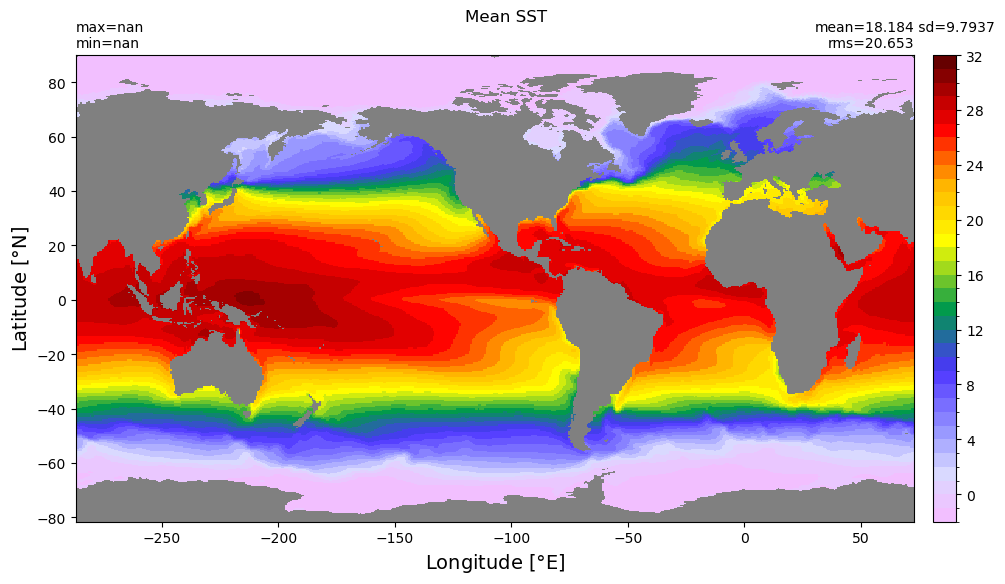

In [13]:
%matplotlib inline
# Plot mean SST
from mom6_tools.m6plot import xyplot

area = np.ma.masked_where(grd.wet == 0, np.ma.masked_invalid(grd.areacello))

dummy1 = np.ma.masked_where(grd.wet == 0, ds.tos.mean('time'))

xyplot(dummy1, grd.geolon, grd.geolat, area , suptitle='Mean SST', clim=(-2,32))